In [1]:
from math import sqrt

import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.layers import BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from surprise import Reader, Dataset, SVD
from tensorflow.python.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.python.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Concatenate, Conv1D, \
    GlobalMaxPooling1D, Layer
from tensorflow.python.keras.models import Model

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
from unidecode import unidecode
import swifter

from xgboost import XGBClassifier, XGBRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# show complete dataframe in console
pd.set_option('display.max_columns', None)

warnings.filterwarnings('ignore')
%matplotlib inline

# Import Data

In [3]:
train = pd.read_csv("./dataset/train.csv")
test = pd.read_csv("./dataset/test.csv")
books = pd.read_csv("./dataset/cleaned_books.csv")
users = pd.read_csv("./dataset/user_info.csv")

# EDA

### Train

In [4]:
train.head()

User_Id  Book_Id  Rating
0   206641    56067       6
1    96769   327469      10
2   149881   325723       5
3   104656   115894       8
4   107921   236817      10

In [5]:
train.describe()

User_Id        Book_Id         Rating
count  303216.000000  303216.000000  303216.000000
mean   140831.385448  167938.250904       7.755072
std     79826.132368   96866.070691      86.018692
min         2.000000       2.000000       1.000000
25%     70374.000000   83937.000000       7.000000
50%    144550.000000  168286.000000       8.000000
75%    209352.000000  251473.000000       9.000000
max    278858.000000  334342.000000   47363.000000

In [6]:
train['Rating'].value_counts()

8        72613
10       54613
7        53678
9        47240
5        35904
6        25786
4         6116
3         4149
2         1896
1         1220
47363        1
Name: Rating, dtype: int64

In [7]:
train['Rating'] = train['Rating'].apply(lambda x: 10 if x > 10 else x)

<Axes: xlabel='Rating', ylabel='Density'>

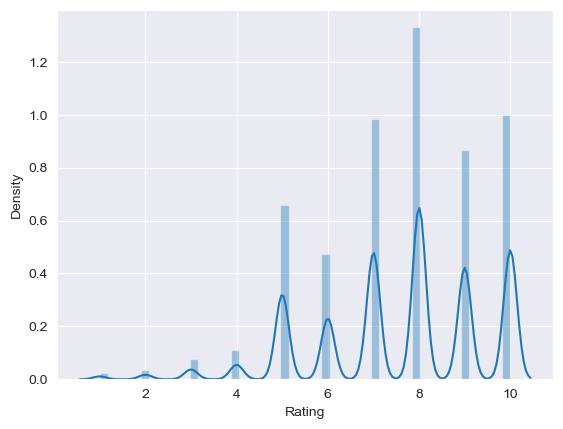

In [8]:
# distribution of rating
sns.distplot(train['Rating'])

In [9]:
# missing values
train.isnull().sum()

User_Id    0
Book_Id    0
Rating     0
dtype: int64

### Test

In [10]:
test.head()

User_Id  Book_Id
0    51757   112562
1   167329   233532
2   115450    62910
3    71697    64447
4   255816    28554

In [11]:
test.describe()

User_Id        Book_Id
count   47522.000000   47522.000000
mean   142520.973444  167381.549093
std     79456.934195   96927.857980
min        76.000000      11.000000
25%     71697.000000   83355.000000
50%    148556.000000  167235.000000
75%    210912.000000  251641.500000
max    278826.000000  334325.000000

In [12]:
test.isnull().sum()

User_Id    0
Book_Id    0
dtype: int64

### Books

In [13]:
books.head()

book_id                                              title  \
0     6036  Ecclesiastical History of the English People W...   
1   248755   Rebecca of Sunnybrook Farm Wordsworth Collection   
2   100080   No 2243 The Pregnant Mistress Harlequin Presents   
3   216944                                                Izo   
4    60313                                          Bad Blood   

                author  year                           publisher  \
0                 Bede  1991                       Penguin Books   
1  Kate Douglas Wiggin  1999  NTCContemporary Publishing Company   
2        Sandra Marton  2002                           Harlequin   
3       Pascal de Duve  1994                                 LGF   
4          Debra Doyle  1993                   Berkley Pub Group   

                                         image_url_s  \
0  http://images.amazon.com/images/P/014044565X.0...   
1  http://images.amazon.com/images/P/1853261343.0...   
2  http://images.amazon.com/images/P/0373122438.0...   
3  http://images.amazon.com/images/P/2253135224.0...   
4  http://images.amazon.com/images/P/0425139530.0...   

                                         image_url_m  \
0  http://images.amazon.com/images/P/014044565X.0...   
1  http://images.amazon.com/images/P/1853261343.0...   
2  http://images.amazon.com/images/P/0373122438.0...   
3  http://images.amazon.com/images/P/2253135224.0...   
4  http://images.amazon.com/images/P/0425139530.0...   

                                         image_url_l  
0  http://images.amazon.com/images/P/014044565X.0...  
1  http://images.amazon.com/images/P/1853261343.0...  
2  http://images.amazon.com/images/P/0373122438.0...  
3  http://images.amazon.com/images/P/2253135224.0...  
4  http://images.amazon.com/images/P/0425139530.0...

In [14]:
books.columns

Index(['book_id', 'title', 'author', 'year', 'publisher', 'image_url_s',
       'image_url_m', 'image_url_l'],
      dtype='object')

In [15]:
books = books[['book_id', 'title', 'author', 'year', 'publisher']]

In [16]:
books.isnull().sum()

book_id      0
title        0
author       1
year         0
publisher    5
dtype: int64

In [17]:
# replace missing values with 'unknown'
books['author'] = books['author'].fillna('unknown')
books['publisher'] = books['publisher'].fillna('unknown')

In [18]:
books.describe()

book_id           year
count  271379.000000  271379.000000
mean   167123.717734    1960.010653
std     96577.950048     275.531085
min         1.000000       0.000000
25%     83463.500000    1989.000000
50%    167091.000000    1995.000000
75%    250837.000000    2000.000000
max    334344.000000   37547.000000

In [19]:
# year
min_year = books['year'].min()
max_year = books['year'].max()
print(min_year, max_year)

0 37547


In [20]:
# replace year < 1700 and year > 2020 with mean year
mean_year = books['year'].mean()
books['year'] = books['year'].apply(lambda x: mean_year if x < 1700 or x > 2020 else x)

<Axes: xlabel='year', ylabel='Density'>

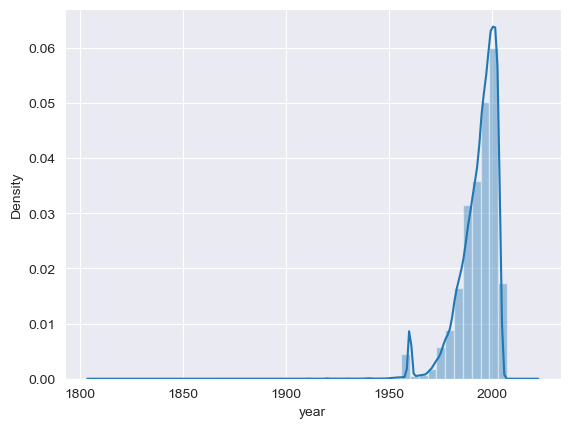

In [21]:
# distribution of year
sns.distplot(books['year'])

In [22]:
# unique values
print("Number of unique books: ", books['book_id'].nunique())
print("Number of unique authors: ", books['author'].nunique())
print("Number of unique publishers: ", books['publisher'].nunique())

Number of unique books:  271378
Number of unique authors:  100963
Number of unique publishers:  16623


In [23]:
# Most books by author
books['author'].value_counts().head(10)

Agatha Christie        632
William Shakespeare    567
Stephen King           524
Ann M Martin           428
Carolyn Keene          373
Francine Pascal        373
Isaac Asimov           330
Nora Roberts           315
Barbara Cartland       307
Charles Dickens        302
Name: author, dtype: int64

In [24]:
# Most books by publisher
books['publisher'].value_counts().head(10)

Harlequin                   7536
Silhouette                  4220
Pocket                      3905
Ballantine Books            3783
Bantam Books                3647
Scholastic                  3160
Simon amp Schuster          2971
Penguin Books               2845
Berkley Publishing Group    2771
Warner Books                2727
Name: publisher, dtype: int64

### Users

In [25]:
users.head()

User_Id                               Location   Age
0        1  kawerau., bay of plenty., new zealand  65.0
1        2                     austin, texas, usa   NaN
2        3              milpitas, california, usa  44.0
3        4           sao paulo, sao paulo, brazil  47.0
4        5                  verona, veneto, italy  38.0

In [26]:
users.columns

Index(['User_Id', 'Location', 'Age'], dtype='object')

In [27]:
users.rename(columns={'User_Id': 'user_id', 'Location': 'location', 'Age': 'age'}, inplace=True)

In [28]:
users.isnull().sum()

user_id          0
location         0
age         110762
dtype: int64

In [29]:
# create a new column country by splitting the location column on commas and taking the last element
users['country'] = users['location'].str.split(',').str[-1]

# replace quotes in the country column with nothing
users['country'] = users['country'].str.replace('"', '')
users['country'] = users['country'].str.strip()

In [30]:
users['country'].value_counts()

usa                  139712
canada                21658
united kingdom        18556
germany               17073
spain                 13258
                      ...  
jackson                   1
&#32654;&#22269;          1
brunei darussalam         1
orense                    1
c.a.                      1
Name: country, Length: 630, dtype: int64

In [31]:
# Source: https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv
# read in the countries csv file from the above url
countries = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")
# convert all the column values to lowercase if they are strings
countries = countries.applymap(lambda x: x.lower().strip() if type(x) == str else x)
countries_names =  countries['name'].values
countries_alpha2 = countries['alpha-2'].values
countries_alpha3 = countries['alpha-3'].values

In [32]:
# rename the country column of df to name if the value matches name, alpha-2, or alpha-3 in the countries dataframe else set it to other

users['temp_country'] = users['country'].str.replace('united states', 'united states of america')

users['temp_country'] = users['temp_country'].apply(lambda x: countries[countries['alpha-2'] == x]['name'].values[0] if x in countries_alpha2 else x)

users['temp_country'] = users['temp_country'].apply(lambda x: countries[countries['alpha-3'] == x]['name'].values[0] if x in countries_alpha3 else x)

users['temp_country'] = users['temp_country'].apply(lambda x: 'other' if x not in countries_names else x)

# delete the country column
users.drop(columns=['country'], inplace=True)
users.drop(columns=['location'], inplace=True)

# rename the country2 column to country
users.rename(columns={'temp_country': 'country'}, inplace=True)

users['country'].value_counts()

united states of america    139729
other                        25833
canada                       21659
germany                      17074
spain                        13258
                             ...  
comoros                          1
madagascar                       1
brunei darussalam                1
somalia                          1
kiribati                         1
Name: country, Length: 179, dtype: int64

In [33]:
# add a new column region by mapping the country column to the region column in the countries dataframe if the country is in the countries dataframe else set it to other
users['region'] = users['country'].apply(lambda x: countries[countries['name'] == x]['region'].values[0] if x in countries_names else 'other')

users['region'].value_counts()

americas    166417
europe       62217
other        25833
oceania      14947
asia          8320
africa        1097
Name: region, dtype: int64

In [34]:
print("Missing age percentage: ", users['age'].isna().sum() / users.shape[0] * 100, "%")

Missing age percentage:  39.71985741847105 %


In [35]:
# Mean average age by country
users.groupby('country')['age'].mean().sort_values(ascending=False)

country
chad                                                    75.500000
bhutan                                                  56.666667
tonga                                                   56.000000
isle of man                                             53.000000
antigua and barbuda                                     52.125000
                                                          ...    
mauritania                                                    NaN
myanmar                                                       NaN
russian federation                                            NaN
somalia                                                       NaN
united kingdom of great britain and northern ireland          NaN
Name: age, Length: 179, dtype: float64

<Axes: >

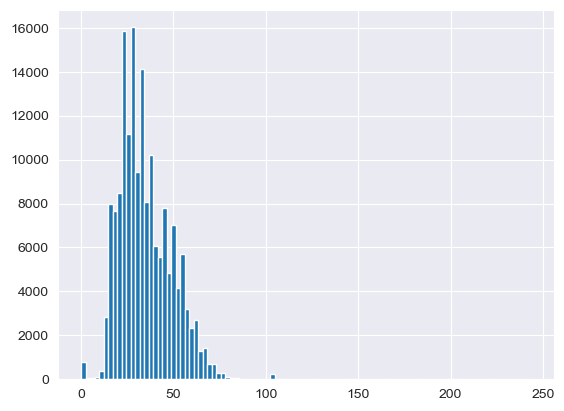

In [36]:
users['age'].hist(bins=100)

In [37]:
# min and max age
print("Min age: ", users['age'].min())
print("Max age: ", users['age'].max())

Min age:  0.0
Max age:  244.0


In [38]:
# replace age > 100 with mean age
mean_age = users['age'].mean()
users['age'] = users['age'].apply(lambda x: mean_age if x > 100 else x)

In [39]:
# replace age < 3 with 5
users['age'] = users['age'].apply(lambda x: 5 if x < 3 else x)

<Axes: >

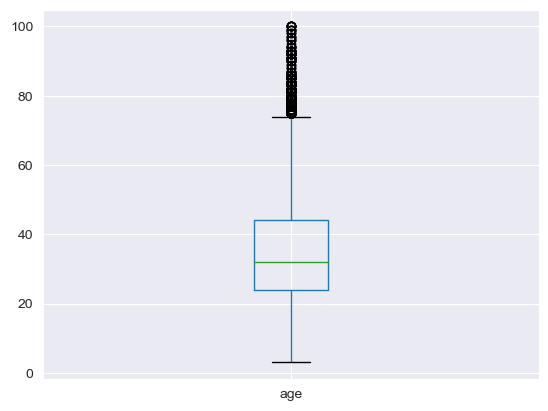

In [40]:
users.boxplot(column=['age'])

In [41]:
# fill the missing values in the age column with 0 and another column for age missing
users['age_missing'] = users['age'].isna()
users['age'] = users['age'].fillna(0)

In [42]:
users.head()

user_id   age                   country    region  age_missing
0        1  65.0               new zealand   oceania        False
1        2   0.0  united states of america  americas         True
2        3  44.0  united states of america  americas        False
3        4  47.0                    brazil  americas        False
4        5  38.0                     italy    europe        False

In [43]:
train = train.rename(columns={'User_Id': 'user_id', 'Rating': 'rating', 'Book_Id': 'book_id'})
test = test.rename(columns={'User_Id': 'user_id', 'Book_Id': 'book_id'})
users = users.rename(columns={'User_Id': 'user_id', 'Location': 'location', 'Age': 'age'})

# Merge train with meta data

In [44]:
print("Train shape: ", train.shape)
data = pd.merge(train, books, on='book_id', how='left')
print("Train shape after merging with books: ", data.shape)
data = pd.merge(data, users, on='user_id', how='left')
print("Train shape after merging with users: ", data.shape)

Train shape:  (303216, 3)
Train shape after merging with books:  (303219, 7)
Train shape after merging with users:  (303219, 11)


In [45]:
data.head()

user_id  book_id  rating  \
0   206641    56067       6   
1    96769   327469      10   
2   149881   325723       5   
3   104656   115894       8   
4   107921   236817      10   

                                               title                 author  \
0  Geography Of Nowhere The Rise And Declineof Am...  James Howard Kunstler   
1   Harry Potter and the Order of the Phoenix Book 5            J K Rowling   
2                        Medinoche El Barco De Vapor          Randolph Stow   
3                              Gotta Get Next to You             Lynn Emery   
4                                               Free           Paul Vincent   

     year           publisher    age                   country    region  \
0  1994.0          Free Press  100.0  united states of america  americas   
1  2003.0          Scholastic    0.0                     other     other   
2  1985.0    Lectorum Pubns J   27.0                     spain    europe   
3  2001.0         HarperTorch   22.0  united states of america  americas   
4  2003.0  Upfront Publishing   29.0                     other     other   

   age_missing  
0        False  
1         True  
2        False  
3        False  
4        False

In [46]:
data.isnull().sum()

user_id            0
book_id            0
rating             0
title          34998
author         34998
year           34998
publisher      34998
age                0
country            0
region            40
age_missing        0
dtype: int64

In [47]:
data.describe()

user_id        book_id         rating           year  \
count  303219.000000  303219.000000  303219.000000  268221.000000   
mean   140831.571996  167937.006494       7.598897    1995.155620   
std     79825.762444   96866.399400       1.839927       8.477624   
min         2.000000       2.000000       1.000000    1806.000000   
25%     70374.000000   83937.000000       7.000000    1992.000000   
50%    144550.000000  168286.000000       8.000000    1997.000000   
75%    209352.000000  251473.000000       9.000000    2001.000000   
max    278858.000000  334342.000000      10.000000    2020.000000   

                 age  
count  303219.000000  
mean       25.685753  
std        19.699771  
min         0.000000  
25%         0.000000  
50%        29.000000  
75%        40.000000  
max       100.000000

<Axes: >

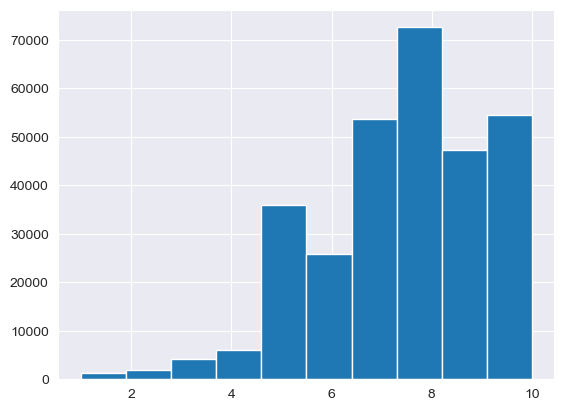

In [48]:
data['rating'].hist(bins=10)

In [49]:
# top rated books
data.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Sport Stretch                                                       10.0
Emilys Black Mail Fold and Mail Stationery Emily the Strange        10.0
The Enchanted Castle Wordsworth Collection Childrens Library        10.0
The Enchanted Hill The story of Hearst Castle at San Simeon         10.0
The Enchanted Tarot Book and Cards                                  10.0
The Enchanted World of RankinBass                                   10.0
EmilyS Captain  March Madness Harlequin Historical                  10.0
The Encyclopaedia of Celtic Wisdom The Celtic Shamans Sourcebook    10.0
The Encyclopedia of Ancient Civilizations                           10.0
The Encyclopedia of Healing Plants                                  10.0
Name: rating, dtype: float64

In [50]:
# top rated authors
data.groupby('author')['rating'].mean().sort_values(ascending=False).head(10)

author
 17111776 Hume      10.0
Laura Berkeley      10.0
Candlewick Press    10.0
Candie Frankel      10.0
Lan Cao             10.0
Lance Morrow        10.0
Lance Parkin        10.0
Lanier Graham       10.0
Lao Tsu             10.0
Lara Owen           10.0
Name: rating, dtype: float64

In [51]:
# most rated books
data.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

title
The Lovely Bones A Novel                          491
Wild Animus                                       409
The Da Vinci Code                                 329
The Secret Life of Bees                           288
Bridget Joness Diary                              269
The Red Tent Bestselling Backlist                 268
The Nanny Diaries A Novel                         258
A Painted House                                   247
Harry Potter and the Chamber of Secrets Book 2    227
Life of Pi                                        221
Name: rating, dtype: int64

<Axes: ylabel='title'>

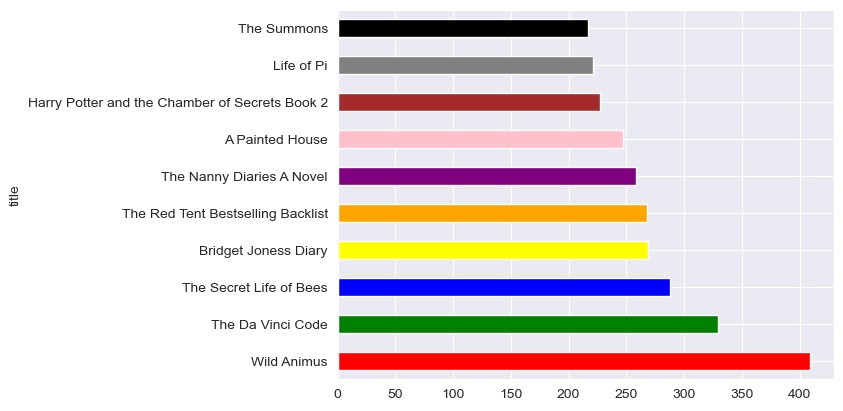

In [52]:
# plot the top 10 most rated books, X-axis = count and y-axis movie, and add colors to the bars
data.groupby('title')['rating'].count().sort_values(ascending=False).iloc[1:11].plot(kind='barh', color=['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'brown', 'grey', 'black'])

In [53]:
# top rated books by region
data.groupby(['region', 'title'])['rating'].mean().sort_values(ascending=False)[1:11]

region    title                                                                     
americas  Tickets A Play in One Act                                                     10.0
          Tibetan Folk Tales                                                            10.0
          Joey Pigza Swallowed the Key Joey Pigza Books Hardcover                       10.0
          Tibet                                                                         10.0
          An Album of Memories                                                          10.0
          Thursday Next in the Well Of Lost Plots Thursday Next Novels Penguin Books    10.0
          John Adams and the American Revolution                                        10.0
          An African Prayer Book                                                        10.0
          Thunderstick Spanish Bit Saga of the Plains Indians                           10.0
          John C Ordinary Enlightenment                                       

In [54]:
# replace missing title, author, publisher with unknown
data['title'] = data['title'].fillna('unknown')
data['author'] = data['author'].fillna('unknown')
data['publisher'] = data['publisher'].fillna('unknown')
data['region'] = data['region'].fillna('unknown')

In [55]:
# replace missing year with mean year
data['year'] = data['year'].fillna(data['year'].mean())

In [56]:
data.isna().sum()

user_id        0
book_id        0
rating         0
title          0
author         0
year           0
publisher      0
age            0
country        0
region         0
age_missing    0
dtype: int64

# Merge test with meta data

In [57]:
print("Test shape: ", test.shape)
test_data = pd.merge(test, books, on='book_id', how='left')
print("Test shape after merging with books: ", test_data.shape)
test_data = pd.merge(test_data, users, on='user_id', how='left')
print("Test shape after merging with users: ", test_data.shape)

Test shape:  (47522, 2)
Test shape after merging with books:  (47522, 6)
Test shape after merging with users:  (47522, 10)


In [58]:
test_data.head()

user_id  book_id                                           title  \
0    51757   112562                             The Mists of Avalon   
1   167329   233532                                 The BLACK ALBUM   
2   115450    62910  Harry Potter and the Chamber of Secrets Book 2   
3    71697    64447                              The Wicca Handbook   
4   255816    28554                                      Lily White   

                  author    year     publisher   age  \
0  MARION ZIMMER BRADLEY  1987.0       Del Rey  43.0   
1         Hanif Kureishi  1996.0      Scribner  27.0   
2            J K Rowling  2000.0    Scholastic  38.0   
3         Eileen Holland  2000.0  Weiser Books  63.0   
4           Susan Isaacs  1997.0   HarperTorch  46.0   

                    country    region  age_missing  
0  united states of america  americas        False  
1                  portugal    europe        False  
2  united states of america  americas        False  
3                     other     other        False  
4  united states of america  americas        False

In [59]:
test_data.isnull().sum()

user_id           0
book_id           0
title          4600
author         4600
year           4600
publisher      4600
age               0
country           0
region           12
age_missing       0
dtype: int64

In [60]:
test_data.describe()

user_id        book_id          year           age
count   47522.000000   47522.000000  42922.000000  47522.000000
mean   142520.973444  167381.549093   1994.890276     27.463484
std     79456.934195   96927.857980      8.552716     19.054430
min        76.000000      11.000000   1902.000000      0.000000
25%     71697.000000   83355.000000   1992.000000      0.000000
50%    148556.000000  167235.000000   1997.000000     30.000000
75%    210912.000000  251641.500000   2001.000000     42.000000
max    278826.000000  334325.000000   2005.000000    100.000000

In [61]:
# replace missing title, author, publisher and region with unknown
test_data['title'] = test_data['title'].fillna('unknown')
test_data['author'] = test_data['author'].fillna('unknown')
test_data['publisher'] = test_data['publisher'].fillna('unknown')
test_data['region'] = test_data['region'].fillna('unknown')

In [62]:
# replace missing year with mean year
test_data['year'] = test_data['year'].fillna(data['year'].mean())

In [63]:
test_data.isna().sum()

user_id        0
book_id        0
title          0
author         0
year           0
publisher      0
age            0
country        0
region         0
age_missing    0
dtype: int64

# Modeling

In [64]:
# split the data into train and validation
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [65]:
print("Train data shape: ", train_data.shape)
print("Validation data shape: ", val_data.shape)

Train data shape:  (242575, 11)
Validation data shape:  (60644, 11)


## SVD

In [66]:
svd = SVD(n_epochs=200, n_factors=15, lr_all=0.001, reg_all=0.05)
reader = Reader(rating_scale=(1, 10))
train_data_svd = Dataset.load_from_df(train_data[['user_id', 'book_id', 'rating']], reader)

In [67]:
svd.fit(train_data_svd.build_full_trainset())

In [68]:
# predict the ratings for the validation data
predictions = val_data.apply(lambda x: svd.predict(x['user_id'], x['book_id']).est, axis=1)

In [69]:
# Calculate the RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(val_data['rating'], predictions))

In [70]:
print("RMSE: ", rmse)

RMSE:  1.639888805960191


In [71]:
# predict the ratings for the test data
predictions = test_data.apply(lambda x: svd.predict(x['user_id'], x['book_id']).est, axis=1)

In [72]:
predictions

0        9.670121
1        8.346019
2        6.593337
3        9.198099
4        7.183357
           ...   
47517    9.292715
47518    6.692180
47519    7.759949
47520    7.729147
47521    8.755297
Length: 47522, dtype: float64

In [73]:
submission = pd.read_csv("./dataset/sample_submission.csv")

In [74]:
submission['Rating'] = predictions

In [75]:
submission.to_csv('submission_svd.csv', index=False)

In [76]:
# Grid search for best parameters
param_grid = {'n_epochs': [10, 100, 500], 'lr_all': [0.0005, 0.001, 0.005], 'reg_all': [0.01, 0.05, 0.1]}

In [77]:
from surprise.model_selection import GridSearchCV as GridSearchCVSurprise

gs = GridSearchCVSurprise(SVD, param_grid, measures=['rmse'], cv=2, n_jobs=-1, joblib_verbose=10)

In [78]:
gs.fit(train_data_svd)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  41 out of  54 | elapsed:   48.1s remaining:   15.3s
[Parallel(n_jobs=-1)]: Done  47 out of  54 | elapsed:  1.1min remaining:   10.2s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  1.2min finished


In [79]:
# Get the best set of hyperparameters
best_params = gs.best_params['rmse']
print('Best RMSE:', gs.best_score['rmse'])
print('Best hyperparameters:', best_params)

Best RMSE: 1.6695733178557475
Best hyperparameters: {'n_epochs': 500, 'lr_all': 0.0005, 'reg_all': 0.1}


## XGBoost

In [80]:
train_data.head()

user_id  book_id  rating  \
144978    49019    48902       5   
52814    259486    83781      10   
229011    75302   293333       9   
157957   137736   211866       8   
263928    59875   284366       9   

                                                    title          author  \
144978                                            unknown         unknown   
52814                                        The Brethren    John Grisham   
229011                                         Summerland  Michael Chabon   
157957   paper Junie B Jones and the Yucky Blucky Frui...    Barbara Park   
263928                                     Phantom Leader     Mark Berent   

              year                     publisher   age  \
144978  1995.15562                       unknown   0.0   
52814   2000.00000                        Island  30.0   
229011  2002.00000                  Miramax Kids  40.0   
157957  1995.00000  Random House Childrens Books  34.0   
263928  1992.00000                    Jove Books   0.0   

                         country    region  age_missing  
144978                  malaysia      asia         True  
52814                   portugal    europe        False  
229011  united states of america  americas        False  
157957  united states of america  americas        False  
263928  united states of america  americas         True

In [81]:
test_data.head()

user_id  book_id                                           title  \
0    51757   112562                             The Mists of Avalon   
1   167329   233532                                 The BLACK ALBUM   
2   115450    62910  Harry Potter and the Chamber of Secrets Book 2   
3    71697    64447                              The Wicca Handbook   
4   255816    28554                                      Lily White   

                  author    year     publisher   age  \
0  MARION ZIMMER BRADLEY  1987.0       Del Rey  43.0   
1         Hanif Kureishi  1996.0      Scribner  27.0   
2            J K Rowling  2000.0    Scholastic  38.0   
3         Eileen Holland  2000.0  Weiser Books  63.0   
4           Susan Isaacs  1997.0   HarperTorch  46.0   

                    country    region  age_missing  
0  united states of america  americas        False  
1                  portugal    europe        False  
2  united states of america  americas        False  
3                     other     other        False  
4  united states of america  americas        False

In [82]:
train_xgb = train_data.copy()
test_xgb = test_data.copy()

In [83]:
# convert the categorical columns to category type
encoder = LabelEncoder()
cat_cols = ['author', 'publisher', 'year', 'region', 'age_missing', 'country', 'user_id', 'book_id']

In [84]:
scaler = MinMaxScaler()
num_cols = ['age']

In [85]:
for col in cat_cols:
    train_xgb[col] = encoder.fit_transform(train_xgb[col])
    test_xgb[col] = encoder.fit_transform(test_xgb[col])

In [86]:
train_xgb[num_cols] = scaler.fit_transform(train_xgb[num_cols])
test_xgb[num_cols] = scaler.fit_transform(test_xgb[num_cols])

In [87]:
train_xgb.head()

user_id  book_id  rating  \
144978     9084    18000       5   
52814     48384    30684      10   
229011    13975   107905       9   
157957    25491    77769       8   
263928    11072   104616       9   

                                                    title  author  year  \
144978                                            unknown   43578    80   
52814                                        The Brethren   20927    85   
229011                                         Summerland   29324    87   
157957   paper Junie B Jones and the Yucky Blucky Frui...    3660    79   
263928                                     Phantom Leader   27848    76   

        publisher   age  country  region  age_missing  
144978       8607  0.00       66       2            1  
52814        4146  0.30       90       3            0  
229011       5197  0.40      112       1            0  
157957       6485  0.34      112       1            0  
263928       4285  0.00      112       1            1

In [88]:
X_train_xgb = train_xgb[['author', 'publisher', 'year', 'region', 'age_missing', 'country', 'user_id', 'book_id', 'age']]
y_train_xgb = train_xgb['rating']

X_test_xgb = test_xgb[['author', 'publisher', 'year', 'region', 'age_missing', 'country', 'user_id', 'book_id', 'age']]

In [89]:
# train test split
X_train, X_val, y_train, y_val = train_test_split(X_train_xgb, y_train_xgb, test_size=0.2, random_state=42)

In [90]:
# train the model
xgb_model = XGBRegressor()

In [91]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [92]:
# predict the ratings for the validation data
predictions = xgb_model.predict(X_val)

In [93]:
predictions

array([7.317499 , 7.210125 , 7.6401668, ..., 7.540548 , 7.6343794,
       8.009657 ], dtype=float32)

In [94]:
# Calculate the RMSE
rmse = sqrt(mean_squared_error(y_val, predictions))

print("RMSE: ", rmse)

RMSE:  1.7404442219110507


In [95]:
# predict the ratings for the test data
predictions = xgb_model.predict(X_test_xgb)


In [96]:
predictions

array([7.3578234, 7.87281  , 7.331409 , ..., 6.976823 , 7.3718224,
       7.229645 ], dtype=float32)

In [97]:
submission = pd.read_csv("./dataset/sample_submission.csv")

submission['Rating'] = predictions

submission.to_csv('submission_xgb.csv', index=False)

## XBG Classifier

In [98]:
train_xgb.head()

user_id  book_id  rating  \
144978     9084    18000       5   
52814     48384    30684      10   
229011    13975   107905       9   
157957    25491    77769       8   
263928    11072   104616       9   

                                                    title  author  year  \
144978                                            unknown   43578    80   
52814                                        The Brethren   20927    85   
229011                                         Summerland   29324    87   
157957   paper Junie B Jones and the Yucky Blucky Frui...    3660    79   
263928                                     Phantom Leader   27848    76   

        publisher   age  country  region  age_missing  
144978       8607  0.00       66       2            1  
52814        4146  0.30       90       3            0  
229011       5197  0.40      112       1            0  
157957       6485  0.34      112       1            0  
263928       4285  0.00      112       1            1

In [99]:
test_xgb.head()

user_id  book_id                                           title  author  \
0      723    11823                             The Mists of Avalon    9779   
1     2268    24515                                 The BLACK ALBUM    5588   
2     1601     6629  Harry Potter and the Chamber of Secrets Book 2    6181   
3      992     6836                              The Wicca Handbook    4137   
4     3544     3053                                      Lily White   14481   

   year  publisher   age  country  region  age_missing  
0    56        982  0.43       40       1            0  
1    66       3037  0.27       32       3            0  
2    70       3013  0.38       40       1            0  
3    70       3651  0.63       29       5            0  
4    67       1599  0.46       40       1            0

In [100]:
xgb_clf = XGBClassifier()

In [101]:
xgb_clf.fit(X_train, y_train-1) # subtract 1 to make the ratings start from 0 instead of 1 for the classifier

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [102]:
# predict the ratings for the validation data
predictions = xgb_clf.predict(X_val) + 1 # add 1 to make the ratings start from 1 instead of 0 for the classifier

predictions

array([ 8,  8,  8, ...,  8, 10,  8])

In [103]:
# Calculate the RMSE

rmse = sqrt(mean_squared_error(y_val, predictions))

print("RMSE: ", rmse)

RMSE:  1.9821890632399612


In [104]:
# predict the ratings for the test data
predictions = xgb_clf.predict(X_test_xgb) + 1

predictions

array([ 7,  8, 10, ...,  8,  7,  8])

In [105]:
submission = pd.read_csv("./dataset/sample_submission.csv")

submission['Rating'] = predictions

submission.to_csv('submission_xgb_clf.csv', index=False)

## Using the XGBClassifier output as input to the XGBRegressor

In [106]:
X_train['xgb_rating'] = xgb_clf.predict(X_train) + 1
X_val['xgb_rating'] = xgb_clf.predict(X_val) + 1

In [107]:
X_train.head()

author  publisher  year  region  age_missing  country  user_id  \
88509     8349       6483    82       1            1      112    35991   
6464     37461       1078    76       1            1      112    22464   
132134   43578       8607    80       3            0       74     3697   
282212   35999       3617    83       5            0       81    29449   
127022   31093       3308    85       3            0       39    43404   

        book_id   age  xgb_rating  
88509     73472  0.00           8  
6464     120683  0.00           5  
132134    75252  0.48           8  
282212    86671  0.29          10  
127022    46488  0.21           8

In [108]:
X_val.head()

author  publisher  year  region  age_missing  country  user_id  \
171815   23301       6651    81       1            1      112     4543   
221523   34788       6310    78       1            1      112    17226   
290984   20563        992    75       3            0      102    32045   
290734   34709        360    84       1            0       21    40066   
215368   34762       8081    84       1            0      112    30635   

        book_id   age  xgb_rating  
171815    23449  0.00           8  
221523   100589  0.00           8  
290984    41002  0.41           8  
290734    20077  0.49          10  
215368    33782  0.49           8

In [109]:
# train the model
xgb_model = XGBRegressor()

In [110]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [111]:
# predict the ratings for the validation data
predictions = xgb_model.predict(X_val)
predictions

array([7.3600583, 7.3082237, 7.437581 , ..., 7.210776 , 8.069264 ,
       7.552676 ], dtype=float32)

In [112]:
# Calculate the RMSE
rmse = sqrt(mean_squared_error(y_val, predictions))
print("RMSE: ", rmse)

RMSE:  1.7510146228534578


In [113]:
X_test_xgb['xgb_rating'] = xgb_clf.predict(X_test_xgb) + 1


In [114]:
# predict the ratings for the test data
predictions = xgb_model.predict(X_test_xgb)

In [115]:
predictions

array([7.47733  , 7.6546597, 8.46654  , ..., 7.0320435, 7.406923 ,
       7.650448 ], dtype=float32)

In [116]:
submission = pd.read_csv("./dataset/sample_submission.csv")

In [117]:
submission['Rating'] = predictions

submission.to_csv('submission_xgb_clf_xgb_reg.csv', index=False)

## Grid search for best parameters for the XGBRegressor

In [118]:
# drop the xgb_rating column
X_train.drop('xgb_rating', axis=1, inplace=True)
X_val.drop('xgb_rating', axis=1, inplace=True)

In [119]:
param_grid = {'n_estimators': [1000, 5000], 'learning_rate': [0.05, 0.1, 0.15], 'max_depth': [7]}

In [120]:
gs = GridSearchCV(xgb_model, param_grid, scoring='neg_mean_squared_error', cv=2, n_jobs=-1, verbose=10)

In [121]:
gs.fit(X_train, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 2/2; 5/6] START learning_rate=0.15, max_depth=7, n_estimators=1000..........
[CV 2/2; 5/6] END learning_rate=0.15, max_depth=7, n_estimators=1000;, score=-3.002 total time= 1.3min
[CV 1/2; 5/6] START learning_rate=0.15, max_depth=7, n_estimators=1000..........
[CV 1/2; 5/6] END learning_rate=0.15, max_depth=7, n_estimators=1000;, score=-3.000 total time= 1.3min
[CV 1/2; 3/6] START learning_rate=0.1, max_depth=7, n_estimators=1000...........
[CV 1/2; 3/6] END learning_rate=0.1, max_depth=7, n_estimators=1000;, score=-2.984 total time= 1.3min
[CV 2/2; 3/6] START learning_rate=0.1, max_depth=7, n_estimators=1000...........
[CV 2/2; 3/6] END learning_rate=0.1, max_depth=7, n_estimators=1000;, score=-2.990 total time= 1.3min


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.15], 'max_depth': [7],
                         'n_estimators': [1000, 5000]},
             scoring='neg_mean_squared_error', verbose=10)

In [122]:
# Get the best set of hyperparameters
best_params = gs.best_params_
print('Best RMSE:', sqrt(-gs.best_score_))
print('Best hyperparameters:', best_params)

Best RMSE: 1.7283323784695503
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 1000}


In [123]:
# train the model
xgb_model = XGBRegressor(n_estimators=best_params['n_estimators'], learning_rate=best_params['learning_rate'], max_depth=best_params['max_depth'])

In [124]:
X_train['xgb_clf_rating'] = xgb_clf.predict(X_train) + 1
X_val['xgb_clf_rating'] = xgb_clf.predict(X_val) + 1

X_train['svd_rating'] = X_train.apply(lambda row: svd.predict(row['user_id'], row['book_id']).est, axis=1)
X_val['svd_rating'] = X_val.apply(lambda row: svd.predict(row['user_id'], row['book_id']).est, axis=1)

In [125]:
# scale the ratings
X_train['svd_rating'] = scaler.fit_transform(X_train['svd_rating'].values.reshape(-1, 1))
X_val['svd_rating'] = scaler.fit_transform(X_val['svd_rating'].values.reshape(-1, 1))

X_train['xgb_clf_rating'] = scaler.fit_transform(X_train['xgb_clf_rating'].values.reshape(-1, 1))
X_val['xgb_clf_rating'] = scaler.fit_transform(X_val['xgb_clf_rating'].values.reshape(-1, 1))

In [126]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [127]:
# predict the ratings for the validation data
predictions = xgb_model.predict(X_val)
predictions

array([7.2960134, 7.071744 , 8.0080805, ..., 7.3103766, 7.946098 ,
       7.6988373], dtype=float32)

In [128]:
# Calculate the RMSE
rmse = sqrt(mean_squared_error(y_val, predictions))
print("RMSE: ", rmse)

RMSE:  1.732692037237727


In [129]:
X_test_xgb.drop('xgb_rating', axis=1, inplace=True)

In [130]:
X_test_xgb['xgb_clf_rating'] = xgb_clf.predict(X_test_xgb) + 1
X_test_xgb['svd_rating'] = X_test_xgb.apply(lambda row: svd.predict(row['user_id'], row['book_id']).est, axis=1)

In [131]:
# scale the ratings
X_test_xgb['svd_rating'] = scaler.fit_transform(X_test_xgb['svd_rating'].values.reshape(-1, 1))
X_test_xgb['xgb_clf_rating'] = scaler.fit_transform(X_test_xgb['xgb_clf_rating'].values.reshape(-1, 1))

In [132]:
# predict the ratings for the test data
predictions = xgb_model.predict(X_test_xgb)
predictions

array([6.276332 , 7.56016  , 8.276598 , ..., 6.1802816, 7.1553493,
       7.3081765], dtype=float32)

In [133]:
submission = pd.read_csv("./dataset/sample_submission.csv")

submission['Rating'] = predictions

submission.to_csv('submission_xgb_clf_svd_xgb_reg.csv', index=False)

In [134]:
# average rating of SVD and XGBRegressor
submission_xgb = pd.read_csv('submission_xgb.csv')
submission_svd = pd.read_csv('submission_svd.csv')

submission['Rating'] = (submission_xgb['Rating'] + submission_svd['Rating']) / 2

submission.to_csv('submission_xgb_svd_avg.csv', index=False)

In [135]:
# average rating of SVD, XGBClassifier and XGBRegressor
submission_xgb_clf = pd.read_csv('submission_xgb_clf.csv')

submission['Rating'] = (submission_xgb['Rating'] * 0.3 + submission_svd['Rating'] * 0.4 + submission_xgb_clf['Rating'] * 0.3)

submission.to_csv('submission_xgb_svd_xgb_clf_avg.csv', index=False)

In [136]:
# average rating of SVD, XGBClassifier
submission_xgb_clf = pd.read_csv('submission_xgb_clf.csv')

submission['Rating'] = (submission_svd['Rating'] * 0.6 + submission_xgb_clf['Rating'] * 0.4)

submission.to_csv('submission_svd_xgb_clf_weighted_avg.csv', index=False)

In [137]:
# average rating of SVD, XGBClassifier
submission_xgb_clf = pd.read_csv('submission_xgb_clf.csv')

submission['Rating'] = (submission_svd['Rating'] + submission_xgb_clf['Rating']) / 2

submission.to_csv('submission_svd_xgb_clf_avg.csv', index=False)

In [138]:
from math import floor, ceil

def round_rating_to_nearest_even(rating):
    """
    7.36 -> 7
    7.64 -> 7.5
    7.5 -> 7.5
    6.5 -> 6.5
    6.4 -> 6
    6.6 -> 7
    """
    if rating % 1 == 0:
        return rating
    elif 0 < rating % 1 <= 0.25:
        return floor(rating)
    elif 0.25 < rating % 1 <= 0.75:
        return floor(rating) + 0.5
    else:
        return ceil(rating)

In [139]:
submission['Rating'] = submission_svd['Rating'].apply(round_rating_to_nearest_even)

submission.to_csv('submission_svd_rounded.csv', index=False)